In [ ]:
!pip install wandb
import wandb
wandb.login(key="580e769ee2f34eafdded556ce52aaf31c265ad3b")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m011 (ma23m011-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Attention

In [ ]:
import torch  # Import PyTorch main library
import torch.nn as nn  # Import neural network modules
import torch.optim as optim  # Import optimization algorithms
import wandb  # Import Weights & Biases for experiment tracking
from torch.utils.data import Dataset, DataLoader  # Import tools for handling datasets and loading data
from sklearn.model_selection import train_test_split  # Import function to split data into train and test sets
import pandas as pd  # Import pandas for data handling
import csv  # Import csv module for reading and writing CSV files



class TransliterationDataset(Dataset):  # Custom dataset for transliteration
    def __init__(self, data, src_vocab, tgt_vocab):  # Initialize with data and vocabularies
        self.data = data  # Store input data (list of (src, tgt) pairs)
        self.src_vocab = src_vocab  # Source language vocabulary
        self.tgt_vocab = tgt_vocab  # Target language vocabulary

    def __len__(self):  # Return number of samples
        return len(self.data)

    def __getitem__(self, idx):  # Get one sample from data
        src, tgt = self.data[idx]  # Get source and target text
        src_ids = [self.src_vocab['<sos>']] + \
                  [self.src_vocab.get(c, self.src_vocab['<unk>']) for c in src] + \
                  [self.src_vocab['<eos>']]  # Convert source to IDs with special tokens
        tgt_ids = [self.tgt_vocab['<sos>']] + \
                  [self.tgt_vocab.get(c, self.tgt_vocab['<unk>']) for c in tgt] + \
                  [self.tgt_vocab['<eos>']]  # Convert target to IDs with special tokens
        return torch.tensor(src_ids), torch.tensor(tgt_ids)  # Return as tensors

def collate_fn(batch):  # Function to pad batches to the same length
    src_seqs, tgt_seqs = zip(*batch)  # Separate source and target sequences
    src_padded = nn.utils.rnn.pad_sequence(src_seqs, batch_first=True, padding_value=0)  # Pad source
    tgt_padded = nn.utils.rnn.pad_sequence(tgt_seqs, batch_first=True, padding_value=0)  # Pad target
    return src_padded, tgt_padded  # Return padded batch

# -------------------- Vocab -------------------- #
def build_vocab(data):  # Build vocabulary from list of words
    vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}  # Special tokens
    idx = 4  # Start index for new characters
    for word in data:  # Go through each word
        if isinstance(word, str):  # Check if it's a string
            for char in word:  # Go through each character
                if char not in vocab:  # If character not in vocab
                    vocab[char] = idx  # Add to vocab
                    idx += 1
    return vocab  # Return the vocabulary dictionary

class Attention(nn.Module):  # Attention module
    def __init__(self, hidden_size):  # Initialize with hidden size
        super().__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # Linear layer for attention
        self.v = nn.Linear(hidden_size, 1, bias=False)  # Linear layer to score attention

    def forward(self, hidden, encoder_outputs, mask=None):  # Forward pass
        # hidden: (batch, hidden)
        # encoder_outputs: (batch, seq_len, hidden)
        batch_size, seq_len, _ = encoder_outputs.size()

        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)  # Repeat hidden state across sequence
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # Combine and pass through attn layer
        attention_scores = self.v(energy).squeeze(2)  # Get attention scores

        if mask is not None:  # Apply mask if provided
            attention_scores = attention_scores.masked_fill(mask == 0, -1e10)

        attention_weights = torch.softmax(attention_scores, dim=1)  # Softmax to get attention weights

        # Debug prints
        # print("Attention raw scores (before softmax):")
        # print(attention_scores[0].detach().cpu().numpy())  # just one example
        # print("Attention weights (after softmax):")
        # print(attention_weights[0].detach().cpu().numpy())

        return attention_weights


class Seq2Seq(nn.Module):  # Define a sequence-to-sequence model with attention
    def __init__(self, config, src_vocab_size, tgt_vocab_size):  # Initialize with config and vocab sizes
        super().__init__()
        self.attention = Attention(config['hidden_size'])  # Attention module
        self.config = config  # Store config dictionary

        # Embedding layers for source and target sequences
        self.embedding_src = nn.Embedding(src_vocab_size, config['embedding_dim'], padding_idx=0)
        self.embedding_tgt = nn.Embedding(tgt_vocab_size, config['embedding_dim'], padding_idx=0)

        # Choose RNN cell type (RNN, GRU, or LSTM)
        rnn_cell = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[config['cell_type']]

        # Define encoder RNN
        self.encoder = rnn_cell(
            config['embedding_dim'], config['hidden_size'],
            config['encoder_layers'], dropout=config['dropout'], batch_first=True)

        # Define decoder RNN (takes embedding + attention context)
        self.decoder_rnn = rnn_cell(
            config['embedding_dim'] + config['hidden_size'], config['hidden_size'],
            config['decoder_layers'], dropout=config['dropout'], batch_first=True)

        # Final linear layer to map hidden state to target vocabulary
        self.fc_out = nn.Linear(config['hidden_size'], tgt_vocab_size)

    def forward(self, src, tgt, return_attn=False):  # Forward pass
        embedded_src = self.embedding_src(src)  # Embed source input
        embedded_tgt = self.embedding_tgt(tgt)  # Embed target input

        encoder_outputs, hidden = self.encoder(embedded_src)  # Run encoder

        # Handle LSTM hidden state (tuple of h and c)
        if isinstance(hidden, tuple):
            h, c = hidden
            h = self._expand_hidden(h, self.config['decoder_layers'])  # Adjust hidden layers
            c = self._expand_hidden(c, self.config['decoder_layers'])
            decoder_hidden = (h, c)  # Pack back as LSTM hidden state
        else:
            hidden = self._expand_hidden(hidden, self.config['decoder_layers'])  # For GRU/RNN
            decoder_hidden = hidden

        batch_size, tgt_len, _ = embedded_tgt.size()  # Get batch size and target sequence length
        decoder_outputs = []  # List to collect decoder outputs
        all_attn_weights = []  # List to collect attention weights

        for t in range(tgt_len):  # Loop over each time step
            tgt_t = embedded_tgt[:, t, :].unsqueeze(1)  # Get embedding at time t

            # Get last hidden state for attention
            if isinstance(decoder_hidden, tuple):
                h_t = decoder_hidden[0][-1]  # For LSTM
            else:
                h_t = decoder_hidden[-1]  # For GRU/RNN

            # Compute attention weights and context vector
            attn_weights = self.attention(h_t, encoder_outputs)  # Shape: (B, S)
            attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # Shape: (B, 1, H)

            # Concatenate context vector with target embedding
            decoder_input = torch.cat((tgt_t, attn_applied), dim=2)  # Shape: (B, 1, H+E)

            # Run decoder RNN one step
            output, decoder_hidden = self.decoder_rnn(decoder_input, decoder_hidden)

            decoder_outputs.append(output)  # Collect output
            all_attn_weights.append(attn_weights)  # Collect attention weights

        decoder_outputs = torch.cat(decoder_outputs, dim=1)  # Combine outputs over all timesteps
        output = self.fc_out(decoder_outputs)  # Final linear layer to get logits

        if return_attn:  # Return attention if needed
            attn_tensor = torch.stack(all_attn_weights, dim=1)  # Shape: (B, T, S)
            return output, attn_tensor

        return output  # Return decoder output

    def _expand_hidden(self, h_enc, required_layers):  # Ensure hidden state has correct number of layers
        num_enc_layers = h_enc.size(0)  # Get actual number of encoder layers
        if num_enc_layers < required_layers:  # If less than needed
            # Create extra zero layers
            extra = torch.zeros(required_layers - num_enc_layers, h_enc.size(1), h_enc.size(2), device=h_enc.device)
            h_enc = torch.cat([h_enc, extra], dim=0)  # Concatenate to match required layers
        else:
            h_enc = h_enc[-required_layers:]  # Trim to needed layers
        return h_enc  # Return expanded/trimmed hidden state


def calculate_accuracy(output, target, pad_idx):
    preds = output.argmax(2)               # Get the index of the highest score (predicted token) at each position
    mask = (target != pad_idx)             # Create a mask to ignore padded positions
    correct = (preds == target) & mask     # Check which predictions are correct, ignoring pads
    return correct.sum().item() / mask.sum().item()  # Return the ratio of correct predictions (token-level accuracy)


def compute_word_accuracy(output, target, tgt_index_to_token, pad_idx):
    preds = output.argmax(dim=2)           # Get predicted token indices (shape: [batch, seq_len])
    correct = 0                             # Initialize correct sequence counter
    total = 0                               # Initialize total sequence counter

    for pred_seq, tgt_seq in zip(preds, target):  # Loop through each sequence pair
        # Convert predicted indices to tokens, ignoring pad tokens
        pred_tokens = [tgt_index_to_token[idx.item()] for idx in pred_seq if idx.item() != pad_idx]
        # Convert target indices to tokens, ignoring pad tokens
        tgt_tokens = [tgt_index_to_token[idx.item()] for idx in tgt_seq if idx.item() != pad_idx]

        # Cut off tokens after <eos> in predicted sequence, if present
        if '<eos>' in pred_tokens:
            pred_tokens = pred_tokens[:pred_tokens.index('<eos>')]
        # Cut off tokens after <eos> in target sequence, if present
        if '<eos>' in tgt_tokens:
            tgt_tokens = tgt_tokens[:tgt_tokens.index('<eos>')]

        if pred_tokens == tgt_tokens:      # If entire predicted sentence matches target sentence
            correct += 1                   # Count as correct
        total += 1                         # Count total sentences

    return correct / total if total > 0 else 0.0  # Return sequence-level (word) accuracy


def train(model, dataloader, optimizer, criterion, tgt_pad_idx, tgt_index_to_token):
    model.train()  # Set the model to training mode
    total_loss, total_acc, total_word_acc = 0, 0, 0  # Initialize totals for loss, accuracy, word accuracy

    for src, tgt in dataloader:  # Loop over each batch of data
        src, tgt = src.to(device), tgt.to(device)  # Move data to GPU (if available)
        optimizer.zero_grad()  # Clear previous gradients

        output = model(src, tgt[:, :-1])  # Run model on source and input part of target (excluding <eos>)
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))  # Compute loss between prediction and shifted target

        acc = calculate_accuracy(output, tgt[:, 1:], tgt_pad_idx)  # Compute token-level accuracy
        word_acc = compute_word_accuracy(output, tgt[:, 1:], tgt_index_to_token, tgt_pad_idx)  # Compute sentence-level accuracy

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model weights

        total_loss += loss.item()  # Add current loss to total loss
        total_acc += acc  # Add current token accuracy to total
        total_word_acc += word_acc  # Add current word accuracy to total

    return total_loss / len(dataloader), total_acc / len(dataloader), total_word_acc / len(dataloader)  # Return average metrics

def evaluate(model, dataloader, criterion, tgt_pad_idx, tgt_index_to_token):
    model.eval()  # Set model to evaluation mode
    total_loss, total_acc, total_word_acc = 0, 0, 0  # Initialize totals

    with torch.no_grad():  # Disable gradient tracking
        for src, tgt in dataloader:  # Loop over validation/test batches
            src, tgt = src.to(device), tgt.to(device)  # Move data to device

            output = model(src, tgt[:, :-1])  # Run model on source and input part of target
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt[:, 1:].reshape(-1))  # Compute loss

            acc = calculate_accuracy(output, tgt[:, 1:], tgt_pad_idx)  # Token-level accuracy
            word_acc = compute_word_accuracy(output, tgt[:, 1:], tgt_index_to_token, tgt_pad_idx)  # Sentence-level accuracy

            total_loss += loss.item()  # Add loss
            total_acc += acc  # Add token accuracy
            total_word_acc += word_acc  # Add word accuracy

    return total_loss / len(dataloader), total_acc / len(dataloader), total_word_acc / len(dataloader)  # Return average results


def sweep_train():
    wandb.init()  # Initialize a new wandb run
    config = wandb.config  # Get hyperparameters from wandb config

    # Load training data (Bengali transliteration), assign column names
    train_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])

    # Repeat rows by frequency to upsample common pairs
    train_df = train_df.loc[train_df.index.repeat(train_df['freq'])].reset_index(drop=True)

    # Load development (validation) data
    dev_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])

    # Ensure source and target text are strings
    train_df['src'] = train_df['src'].astype(str)
    train_df['tgt'] = train_df['tgt'].astype(str)

    # Build vocabularies for source and target
    src_vocab = build_vocab(train_df['src'])
    tgt_vocab = build_vocab(train_df['tgt'])

    # Print source and target vocab sizes
    print("Source Vocab:", src_vocab)
    print("Target Vocab:", tgt_vocab)

    # Create index-to-token mapping for target vocab
    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}
    idx_to_tgt = {v: k for k, v in tgt_vocab.items()}

    # Prepare paired source-target training data
    train_data = list(zip(train_df['src'], train_df['tgt']))
    dev_data = list(zip(dev_df['src'], dev_df['tgt']))

    # Create dataset objects
    train_dataset = TransliterationDataset(train_data, src_vocab, tgt_vocab)
    dev_dataset = TransliterationDataset(dev_data, src_vocab, tgt_vocab)

    # Create data loaders with batch size 32
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize Seq2Seq model with config and vocab sizes
    model = Seq2Seq(config, len(src_vocab), len(tgt_vocab)).to(device)

    # Use Adam optimizer
    optimizer = optim.Adam(model.parameters())

    # Use CrossEntropyLoss and ignore padding token in loss
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

    # Training loop
    for epoch in range(config['epochs']):
        # Train model and get metrics
        train_loss, train_acc, train_word_acc = train(model, train_loader, optimizer, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Evaluate model on validation set
        val_loss, val_acc, val_word_acc = evaluate(model, dev_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Print metrics for current epoch
        print(f"Epoch {epoch + 1}")  # Show current epoch number
        print(f"{'train_loss:':20} {train_loss:.4f}")  # Show training loss
        print(f"{'val_loss:':20} {val_loss:.4f}")  # Show validation loss
        print(f"{'train_accuracy:':20} {train_acc * 100:.2f}%")  # Show training token-level accuracy
        print(f"{'val_accuracy:':20} {val_acc * 100:.2f}%")  # Show validation token-level accuracy
        print(f"{'train_word_accuracy:':20} {train_word_acc * 100:.2f}%")  # Show training word-level accuracy
        print(f"{'val_word_accuracy:':20} {val_word_acc * 100:.2f}%")  # Show validation word-level accuracy

        # Log all metrics to wandb
        wandb.log({
            "epoch": epoch + 1,  # Log current epoch number
            "train_loss": train_loss,  # Log training loss
            "val_loss": val_loss,  # Log validation loss
            "train_accuracy": train_acc * 100,  # Log training token accuracy (%)
            "val_accuracy": val_acc * 100,  # Log validation token accuracy (%)
            "train_word_accuracy": train_word_acc * 100,  # Log training word accuracy (%)
            "val_word_accuracy": val_word_acc * 100  # Log validation word accuracy (%)
        })

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define sweep configuration for hyperparameter tuning
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization for the sweep
    'name': 'DakshinaSweepForAttention123',  # Name of the sweep
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},  # Maximize validation accuracy

    # Define hyperparameters to search over
    'parameters': {
        'embedding_dim': {'values': [32, 64, 128, 256]},  # Size of embeddings
        'hidden_size': {'values': [64, 128]},  # Hidden layer size
        'encoder_layers': {'values': [1, 2, 3]},  # Number of encoder layers
        'decoder_layers': {'values': [1, 2, 3]},  # Number of decoder layers
        'cell_type': {'values': ['GRU', 'LSTM']},  # RNN cell type
        'dropout': {'values': [0.2, 0.3]},  # Dropout rate
        'epochs': {'values': [5, 10, 13, 15]}  # Number of training epochs
    }
}

# Create a new sweep with the given configuration under project "DL_A3_Part_B"
sweep_id = wandb.sweep(sweep_config, project="DL_A3_Part_B")

# Launch the sweep agent to run the training function 10 times with different hyperparameters
wandb.agent(sweep_id, function=sweep_train, count=10)


In [ ]:
def predict_with_beam_search(model, src_seq, src_vocab, tgt_vocab, beam_width=3, max_len=30):
    model.eval()  # Set model to evaluation mode
    sos_token = tgt_vocab['<sos>']  # Get start-of-sequence token
    eos_token = tgt_vocab['<eos>']  # Get end-of-sequence token
    pad_token = tgt_vocab['<pad>']  # Get padding token
    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}  # Create index to token map

    with torch.no_grad():  # Disable gradient calculation
        # Convert source sequence to indices with <sos> and <eos> tokens
        src_indices = [src_vocab['<sos>']] + [src_vocab.get(c, src_vocab['<unk>']) for c in src_seq] + [src_vocab['<eos>']]
        src_tensor = torch.tensor(src_indices, device=device).unsqueeze(0)  # Add batch dimension

        embedded_src = model.embedding_src(src_tensor)  # Embed source tokens

        encoder_outputs, hidden = model.encoder(embedded_src)  # Encode source sequence

        # Handle LSTM hidden state
        if isinstance(hidden, tuple):
            h, c = hidden
        else:
            h, c = hidden, None

        # Expand hidden state to match decoder layers
        if isinstance(hidden, tuple):
            h = model._expand_hidden(h, model.config['decoder_layers'])  # Expand hidden states
            c = model._expand_hidden(c, model.config['decoder_layers'])  # Expand cell states
            decoder_hidden = (h, c)  # Use tuple for LSTM
        else:
            hidden = model._expand_hidden(hidden, model.config['decoder_layers'])  # Expand hidden
            decoder_hidden = hidden  # Use hidden directly

        # Initialize beam with (<sos>, score=0, decoder hidden state)
        beams = [(torch.tensor([sos_token], device=device), 0.0, decoder_hidden)]

        for _ in range(max_len):  # Limit sequence length
            new_beams = []  # Store updated beams

            for seq, score, hidden_state in beams:  # For each beam
                if seq[-1].item() == eos_token:  # If <eos> reached
                    new_beams.append((seq, score, hidden_state))  # Keep as is
                    continue  # Skip decoding

                # Embed last token in the sequence
                embedded = model.embedding_tgt(seq[-1].unsqueeze(0).unsqueeze(0))

                # Get last hidden state from last decoder layer
                if isinstance(hidden_state, tuple):
                    h_last = hidden_state[0][-1]
                else:
                    h_last = hidden_state[-1]

                # Compute attention weights
                attn_weights = model.attention(h_last, encoder_outputs)

                # Apply attention weights to encoder outputs to get context
                context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

                # Combine embedded input and context vector
                decoder_input = torch.cat((embedded, context), dim=2)

                # Decode the input
                if isinstance(hidden_state, tuple):
                    output, new_hidden = model.decoder_rnn(decoder_input, hidden_state)
                else:
                    output, new_hidden = model.decoder_rnn(decoder_input, hidden_state)

                # Compute output logits and apply log softmax
                logits = model.fc_out(output.squeeze(1))
                log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)

                # Select top k tokens with highest log probabilities
                topk_log_probs, topk_indices = torch.topk(log_probs, beam_width)

                for log_prob, idx in zip(topk_log_probs, topk_indices):
                    new_seq = torch.cat([seq, idx.unsqueeze(0)])  # Append new token
                    new_score = score + log_prob.item()  # Update score
                    new_beams.append((new_seq, new_score, new_hidden))  # Save new beam

            # Keep top k beams with highest scores
            beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]

        best_seq = beams[0][0]  # Get sequence with best score

        # Convert predicted token indices to characters
        return ''.join([
            tgt_index_to_token[token.item()] for token in best_seq[1:]  # Skip <sos>
            if token.item() not in [eos_token, pad_token]  # Remove <eos> and <pad>
        ])


In [ ]:
def sweep_train_pred():
    wandb.init()  # Start wandb run
    config = wandb.config  # Get config from sweep

    # Load train dataset
    train_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])
    train_df = train_df.loc[train_df.index.repeat(train_df['freq'])].reset_index(drop=True)  # Repeat rows based on frequency

    # Load dev and test datasets
    dev_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])
    test_df = pd.read_csv('/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv', sep="\t", header=None, names=["tgt", "src", "freq"])

    # Make sure src and tgt are strings
    train_df['src'] = train_df['src'].astype(str)
    train_df['tgt'] = train_df['tgt'].astype(str)

    # Build vocab for source and target
    src_vocab = build_vocab(train_df['src'])
    tgt_vocab = build_vocab(train_df['tgt'])

    print("Source Vocab:", src_vocab)
    print("Target Vocab:", tgt_vocab)
    wandb.log({"src_vocab_size": len(src_vocab), "tgt_vocab_size": len(tgt_vocab)})

    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}  # index to target character

    # Create (src, tgt) data pairs
    train_data = list(zip(train_df['src'], train_df['tgt']))
    dev_data = list(zip(dev_df['src'], dev_df['tgt']))
    test_data = list(zip(test_df['src'], test_df['tgt']))

    # Create dataset objects
    train_dataset = TransliterationDataset(train_data, src_vocab, tgt_vocab)
    dev_dataset = TransliterationDataset(dev_data, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_data, src_vocab, tgt_vocab)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Create model
    model = Seq2Seq(config, len(src_vocab), len(tgt_vocab)).to(device)

    # Set optimizer and loss
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])

    # Train for given number of epochs
    for epoch in range(config['epochs']):
        # Train for one epoch
        train_loss, train_acc, train_word_acc = train(model, train_loader, optimizer, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Evaluate on dev set
        val_loss, val_acc, val_word_acc = evaluate(model, dev_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Evaluate on test set
        test_loss, test_acc, test_word_acc = evaluate(model, test_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Print all metrics
        print(f"Epoch {epoch + 1}")
        print(f"{'train_loss:':20} {train_loss:.4f}")
        print(f"{'val_loss:':20} {val_loss:.4f}")
        print(f"{'test_loss:':20} {test_loss:.4f}")
        print(f"{'train_accuracy:':20} {train_acc * 100:.2f}%")
        print(f"{'val_accuracy:':20} {val_acc * 100:.2f}%")
        print(f"{'test_accuracy:':20} {test_acc * 100:.2f}%")
        print(f"{'train_word_accuracy:':20} {train_word_acc * 100:.2f}%")
        print(f"{'val_word_accuracy:':20} {val_word_acc * 100:.2f}%")
        print(f"{'test_word_accuracy:':20} {test_word_acc * 100:.2f}%")

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "test_loss": test_loss,
            "train_accuracy": train_acc * 100,
            "val_accuracy": val_acc * 100,
            "test_accuracy": test_acc * 100,
            "train_word_accuracy": train_word_acc * 100,
            "val_word_accuracy": val_word_acc * 100,
            "test_word_accuracy": test_word_acc * 100
        })

    # Get beam width from config
    beam_width = config.get('beam_width')
    print('beam_width', beam_width)
    wandb.log({"beam_width": beam_width})

    results = []

    # Run prediction for each sample in test set
    for sample_src, actual_tgt in test_data[:9229]:  # You can increase this if needed
        pred_seq = predict_with_beam_search(model, sample_src, src_vocab, tgt_vocab, beam_width=beam_width)
        pred_tokens = [c for c in pred_seq if c not in ['<sos>', '<pad>', '<eos>']]
        pred_str = ''.join(pred_tokens)

        # Print each prediction
        print(f"Input:      {sample_src}")
        print(f"Actual:     {actual_tgt}")
        print(f"Prediction: {pred_str}")
        print("-" * 30)

        # Add prediction to list
        results.append({
            "Input": sample_src,
            "Actual": actual_tgt,
            "Prediction": pred_str
        })

    # Save predictions to CSV
    output_csv_path = "beam_search_predictions_attention.csv"
    with open(output_csv_path, mode='w', encoding='utf-8-sig', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=["Input", "Actual", "Prediction"])
        writer.writeheader()
        writer.writerows(results)

    print(f"Saved predictions to {output_csv_path}")
    wandb.save(output_csv_path)  # Save file to wandb

    # predict_and_show(model, test_dataset, src_vocab, tgt_vocab, tgt_index_to_token, num_samples=5)


# Set device to GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the hyperparameter sweep configuration
sweep_config = {
    'method': 'random',  # Randomly sample combinations of parameters
    'name': 'DakshinaSweepForAttention_Pred',  # Name of this sweep run
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},  # Maximize validation accuracy
    'parameters': {
        'embedding_dim': {'values': [64]},       # Dimension of embedding layer
        'hidden_size': {'values': [128]},        # Number of hidden units in encoder/decoder
        'encoder_layers': {'values': [2]},       # Number of layers in encoder
        'decoder_layers': {'values': [3]},       # Number of layers in decoder
        'cell_type': {'values': ['LSTM']},       # Type of RNN cell used
        'dropout': {'values': [0.3]},            # Dropout rate
        'epochs': {'values': [13]},              # Number of training epochs
        'beam_width': {'values': [3]}            # Beam width for beam search decoding
    }
}

# Initialize the sweep with Weights & Biases
sweep_id = wandb.sweep(sweep_config, project="DL_A3_Part_B")  # Project name for wandb dashboard

# Run the sweep agent with our training function
wandb.agent(sweep_id, function=sweep_train_pred, count=1)  # Run the training once


Create sweep with ID: w9poiam9
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DL_A3_Part_B/sweeps/w9poiam9


wandb: Agent Starting Run: 44wn618m with config:
wandb: 	beam_width: 3
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	encoder_layers: 2
wandb: 	epochs: 13
wandb: 	hidden_size: 128


{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'a': 4, 'n': 5, 'g': 6, 'k': 7, 'i': 8, 't': 9, 'o': 10, 'e': 11, 'r': 12, 's': 13, 'h': 14, 'y': 15, 'w': 16, 'u': 17, 'l': 18, 'd': 19, 'j': 20, 'b': 21, 'm': 22, 'c': 23, 'q': 24, 'z': 25, 'p': 26, 'x': 27, 'v': 28, 'f': 29}
{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'অ': 4, 'ং': 5, 'ক': 6, 'ি': 7, 'ত': 8, 'ে': 9, 'র': 10, 'শ': 11, 'ই': 12, 'ও': 13, 'গ': 14, 'ু': 15, 'ল': 16, 'ো': 17, '্': 18, 'হ': 19, 'ণ': 20, 'া': 21, 'ী': 22, 'দ': 23, 'ন': 24, 'ট': 25, 'ব': 26, 'ষ': 27, 'ম': 28, 'স': 29, 'খ': 30, 'য': 31, 'ড': 32, 'ৎ': 33, 'ধ': 34, 'ঠ': 35, 'জ': 36, 'প': 37, 'ূ': 38, 'চ': 39, 'ছ': 40, 'ভ': 41, 'ঘ': 42, 'ঙ': 43, 'ৈ': 44, 'ঞ': 45, '়': 46, 'ঃ': 47, 'এ': 48, 'থ': 49, 'ৃ': 50, 'ৌ': 51, 'ফ': 52, 'ঝ': 53, 'আ': 54, 'উ': 55, 'ঁ': 56, 'ঈ': 57, 'ঊ': 58, 'ঋ': 59, 'ঐ': 60, 'ঔ': 61, 'ঢ': 62, '২': 63}
Epoch 1
train_loss:          1.5595
val_loss:            0.6447
test_loss:           0.6326
train_accuracy:      55.83%
val_accuracy:       

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test_accuracy,▁▅▆▇▇▇▇██████
test_loss,█▃▂▂▁▁▂▁▁▁▁▁▂
test_word_accuracy,▁▅▆▆▇▇▇██▇███
train_accuracy,▁▆▇▇▇████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁
train_word_accuracy,▁▄▅▆▆▇▇▇▇████
val_accuracy,▁▅▆▇▇▇▇██████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁
val_word_accuracy,▁▄▆▆▇▇▇██████
epoch,13


# Heatmap

In [ ]:
# Import required libraries
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm

# Load custom Bangla font for text rendering
bangla_font_path = "/kaggle/input/tiro-bn/TiroBangla-Regular.ttf"
bangla_font = fm.FontProperties(fname=bangla_font_path)

# Function to plot a single attention heatmap
def plot_attention(attentions, src_tokens, tgt_tokens, index, ax):
    sns.heatmap(attentions.cpu().detach().numpy(),   # Plot attention matrix as heatmap
                xticklabels=src_tokens,              # Set source tokens as x-axis labels
                yticklabels=tgt_tokens,              # Set target tokens as y-axis labels
                cmap="viridis",                      # Use viridis color map
                cbar=False,                          # Hide color bar
                ax=ax)                               # Plot on given subplot axis

    ax.set_xlabel("Source", fontproperties=bangla_font)       # X-axis label with Bangla font
    ax.set_ylabel("Target", fontproperties=bangla_font)       # Y-axis label with Bangla font
    ax.set_title(f"Sample {index}", fontproperties=bangla_font)  # Title with sample number

    # Set font and rotation for axis tick labels
    ax.set_yticklabels(tgt_tokens, fontproperties=bangla_font, rotation=0)
    ax.set_xticklabels(src_tokens, fontproperties=bangla_font, rotation=45)

# Function to visualize attention maps in a 3x3 grid
def visualize_attention_grid(model, dataloader, src_vocab, tgt_vocab, device):
    src_index_to_token = {v: k for k, v in src_vocab.items()}  # Map index to source token
    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}  # Map index to target token
    model.eval()  # Set model to evaluation mode

    n = 0  # Counter to track plotted samples
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # Create 3x3 grid of subplots
    axes = axes.flatten()  # Flatten axes for easy indexing

    with torch.no_grad():  # Disable gradient tracking for evaluation
        for src_batch, tgt_batch in dataloader:  # Loop over batches from dataloader
            src_batch = src_batch.to(device)  # Move source to device (GPU/CPU)
            tgt_batch = tgt_batch.to(device)  # Move target to device

            # Forward pass with return_attn=True to get attention weights
            output, attn_weights = model(src_batch, tgt_batch[:, :-1], return_attn=True)

            for i in range(src_batch.size(0)):  # Loop over samples in batch
                # Convert source indices to tokens (ignore padding)
                src_seq = [src_index_to_token[idx.item()] for idx in src_batch[i] if idx.item() != src_vocab['<pad>']]
                # Convert target indices to tokens (ignore padding)
                tgt_seq = [tgt_index_to_token[idx.item()] for idx in tgt_batch[i, 1:] if idx.item() != tgt_vocab['<pad>']]

                # Slice attention weights for this sample: (target_len, source_len)
                attn = attn_weights[i, :len(tgt_seq), :len(src_seq)]

                # Plot attention heatmap on subplot
                plot_attention(attn, src_seq, tgt_seq, n+1, axes[n])
                n += 1  # Increment sample counter

                if n == 9:  # Stop after plotting 9 samples
                    plt.tight_layout()  # Adjust layout
                    wandb.log({"Attention Heatmap Grid": wandb.Image(fig)})  # Log to wandb
                    plt.show()  # Show the grid of plots
                    return  # Exit function


Create sweep with ID: kve3g7m3
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DL_A3/sweeps/kve3g7m3


wandb: Agent Starting Run: ujvpb93o with config:
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	encoder_layers: 2
wandb: 	epochs: 13
wandb: 	hidden_size: 128


{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'a': 4, 'n': 5, 'g': 6, 'k': 7, 'i': 8, 't': 9, 'o': 10, 'e': 11, 'r': 12, 's': 13, 'h': 14, 'y': 15, 'w': 16, 'u': 17, 'l': 18, 'd': 19, 'j': 20, 'b': 21, 'm': 22, 'c': 23, 'q': 24, 'z': 25, 'p': 26, 'x': 27, 'v': 28, 'f': 29}
{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'অ': 4, 'ং': 5, 'ক': 6, 'ি': 7, 'ত': 8, 'ে': 9, 'র': 10, 'শ': 11, 'ই': 12, 'ও': 13, 'গ': 14, 'ু': 15, 'ল': 16, 'ো': 17, '্': 18, 'হ': 19, 'ণ': 20, 'া': 21, 'ী': 22, 'দ': 23, 'ন': 24, 'ট': 25, 'ব': 26, 'ষ': 27, 'ম': 28, 'স': 29, 'খ': 30, 'য': 31, 'ড': 32, 'ৎ': 33, 'ধ': 34, 'ঠ': 35, 'জ': 36, 'প': 37, 'ূ': 38, 'চ': 39, 'ছ': 40, 'ভ': 41, 'ঘ': 42, 'ঙ': 43, 'ৈ': 44, 'ঞ': 45, '়': 46, 'ঃ': 47, 'এ': 48, 'থ': 49, 'ৃ': 50, 'ৌ': 51, 'ফ': 52, 'ঝ': 53, 'আ': 54, 'উ': 55, 'ঁ': 56, 'ঈ': 57, 'ঊ': 58, 'ঋ': 59, 'ঐ': 60, 'ঔ': 61, 'ঢ': 62, '২': 63}
Epoch 1
train_loss:          1.7119
val_loss:            0.7587
test_loss:           0.7603
train_accuracy:      51.52%
val_accuracy:       

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

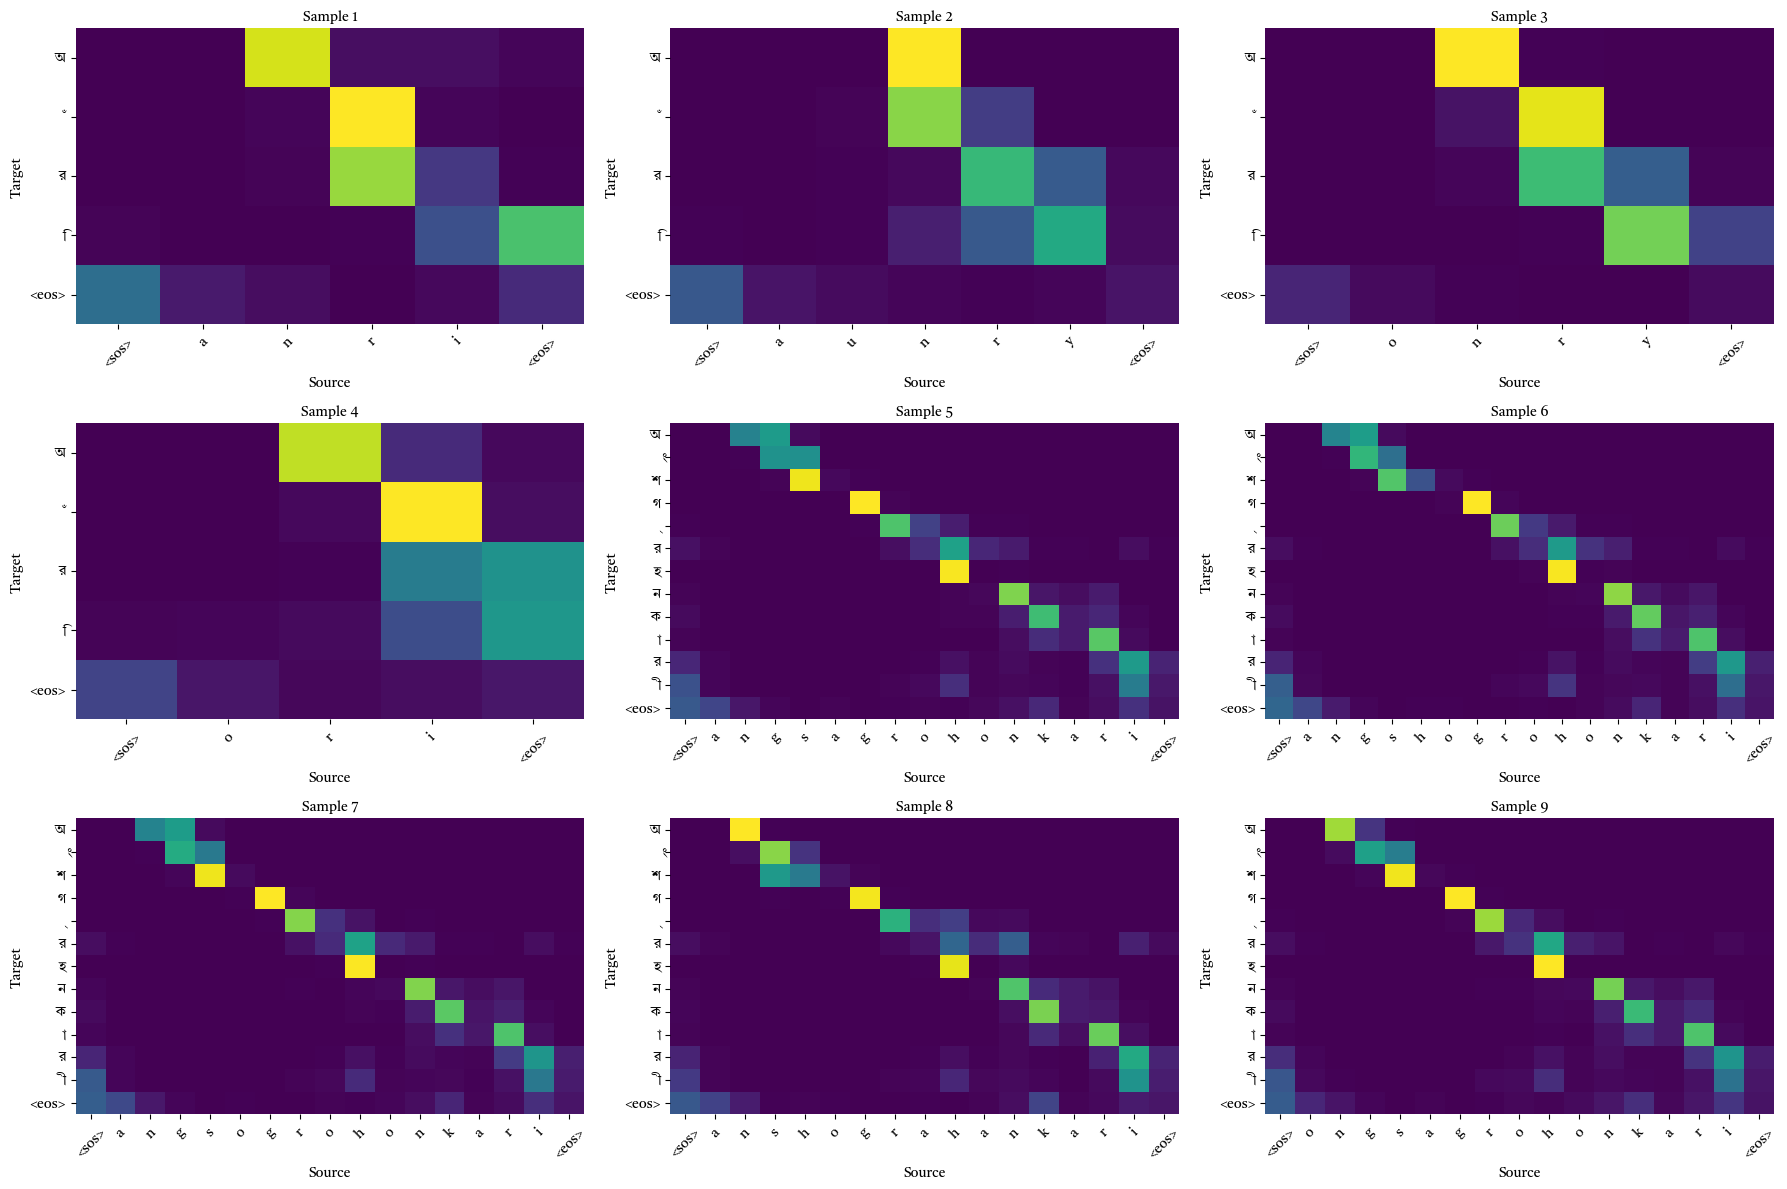

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test_accuracy,▁▅▇▇▇████████
test_loss,█▃▂▁▁▁▁▁▁▁▁▁▁
test_word_accuracy,▁▄▆▆▇▇██▇████
train_accuracy,▁▆▇▇▇████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁
train_word_accuracy,▁▃▅▆▆▇▇▇▇████
val_accuracy,▁▅▇▇▇▇███████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁
val_word_accuracy,▁▄▆▆▇▇▇▇▇████
epoch,13


In [ ]:
# Import the wandb library for logging and hyperparameter sweeps
import wandb
# Other necessary libraries assumed already imported: pandas as pd, torch, DataLoader, etc.

# Function to run one training session during the sweep
def sweep_train_heatmap():
    wandb.init()  # Initialize a new wandb run
    config = wandb.config  # Access the hyperparameter config defined in the sweep

    # Load training dataset (Bangla transliteration) from TSV file into a dataframe
    train_df = pd.read_csv(
        "/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv",
        sep="\t", header=None, names=["tgt", "src", "freq"]
    )

    # Repeat each row in the dataset according to the frequency column
    train_df = train_df.loc[train_df.index.repeat(train_df['freq'])].reset_index(drop=True)

    # Load dev and test datasets similarly (without repeating based on frequency)
    dev_df = pd.read_csv(
        "/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv",
        sep="\t", header=None, names=["tgt", "src", "freq"]
    )
    test_df = pd.read_csv(
        "/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv",
        sep="\t", header=None, names=["tgt", "src", "freq"]
    )

    # Ensure source and target columns are strings
    train_df['src'] = train_df['src'].astype(str)
    train_df['tgt'] = train_df['tgt'].astype(str)

    # Build vocabularies for source and target languages
    src_vocab = build_vocab(train_df['src'])
    tgt_vocab = build_vocab(train_df['tgt'])

    # Print the vocabulary for debugging and inspection
    print(src_vocab)  # Shows the source vocabulary mapping
    print(tgt_vocab)  # Shows the target vocabulary mapping

    # Create reverse lookup for target vocab (index to token)
    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}
    idx_to_tgt = {v: k for k, v in tgt_vocab.items()}  # Duplicate for compatibility

    # Zip source and target columns together to form training tuples
    train_data = list(zip(train_df['src'], train_df['tgt']))
    dev_data = list(zip(dev_df['src'], dev_df['tgt']))
    test_data = list(zip(test_df['src'], test_df['tgt']))

    # Create datasets using the custom TransliterationDataset class
    train_dataset = TransliterationDataset(train_data, src_vocab, tgt_vocab)
    dev_dataset = TransliterationDataset(dev_data, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_data, src_vocab, tgt_vocab)

    # Create DataLoaders for batch processing
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize the sequence-to-sequence model with config hyperparameters
    model = Seq2Seq(config, len(src_vocab), len(tgt_vocab)).to(device)

    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])  # Ignore pad tokens in loss

    # Training loop
    for epoch in range(config['epochs']):
        # Train the model on the training set
        train_loss, train_acc, train_word_acc = train(
            model, train_loader, optimizer, criterion, tgt_vocab['<pad>'], tgt_index_to_token
        )

        # Evaluate on dev and test sets
        val_loss, val_acc, val_word_acc = evaluate(
            model, dev_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token
        )
        test_loss, test_acc, test_word_acc = evaluate(
            model, test_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token
        )

        # Print all metrics for the current epoch
        print(f"Epoch {epoch + 1}")  # Print epoch number
        print(f"{'train_loss:':20} {train_loss:.4f}")  # Training loss
        print(f"{'val_loss:':20} {val_loss:.4f}")      # Validation loss
        print(f"{'test_loss:':20} {test_loss:.4f}")    # Test loss
        print(f"{'train_accuracy:':20} {train_acc * 100:.2f}%")       # Character-level accuracy
        print(f"{'val_accuracy:':20} {val_acc * 100:.2f}%")
        print(f"{'test_accuracy:':20} {test_acc * 100:.2f}%")
        print(f"{'train_word_accuracy:':20} {train_word_acc * 100:.2f}%")  # Word-level accuracy
        print(f"{'val_word_accuracy:':20} {val_word_acc * 100:.2f}%")
        print(f"{'test_word_accuracy:':20} {test_word_acc * 100:.2f}%")

        # Log metrics to wandb for tracking and visualization
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,                    # Loss during training
            "val_loss": val_loss,                        # Loss on dev set
            "test_loss": test_loss,                      # Loss on test set
            "train_accuracy": train_acc * 100,           # Character accuracy on train
            "val_accuracy": val_acc * 100,               # Character accuracy on dev
            "test_accuracy": test_acc * 100,             # Character accuracy on test
            "train_word_accuracy": train_word_acc * 100, # Word-level accuracy on train
            "val_word_accuracy": val_word_acc * 100,     # Word-level accuracy on dev
            "test_word_accuracy": test_word_acc * 100    # Word-level accuracy on test
        })

    # After training, visualize attention weights from test samples
    visualize_attention_grid(model, test_loader, src_vocab, tgt_vocab, device)


# -------------------- Setup and Sweep Configuration -------------------- #

# Select device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a sweep configuration for random hyperparameter search
sweep_config = {
    'method': 'random',  # Use random sampling for hyperparameter combinations
    'name': 'DakshinaSweepForAttention_heatmapFinal123',  # Name of sweep
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},  # Metric to optimize
    'parameters': {
        'embedding_dim': {'values': [64]},          # Embedding dimension for characters
        'hidden_size': {'values': [128]},           # Hidden layer size for encoder/decoder
        'encoder_layers': {'values': [2]},          # Number of encoder layers
        'decoder_layers': {'values': [3]},          # Number of decoder layers
        'cell_type': {'values': ['LSTM']},          # Type of RNN cell
        'dropout': {'values': [0.3]},               # Dropout rate
        'epochs': {'values': [13]},                 # Number of training epochs
    }
}

# Initialize a new sweep and get the sweep ID
sweep_id = wandb.sweep(sweep_config, project="DL_A3_Part_B")

# Launch the sweep agent which runs the training function with different configs
wandb.agent(sweep_id, function=sweep_train_heatmap, count=1)  # Run only 1 trial here


# Connectivity for attention

In [ ]:
# Import Weights & Biases for experiment tracking (optional here)
import wandb

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import seaborn for heatmap plotting
import seaborn as sns

# Import font manager to use custom fonts (Bangla in this case)
from matplotlib import font_manager as fm

# Import PyTorch
import torch

# Specify the path to the Bangla font file
bangla_font_path = "/kaggle/input/tiro-bn/TiroBangla-Regular.ttf"

# Load the Bangla font
bangla_font = fm.FontProperties(fname=bangla_font_path)

# Function to plot the attention heatmap
def plot_attention(attentions, src_tokens, tgt_tokens, index, ax):
    # Convert attention tensor to NumPy array
    attn_np = attentions.cpu().detach().numpy()

    # Plot heatmap of attention scores
    sns.heatmap(attn_np,
                xticklabels=src_tokens,  # Labels for x-axis (input tokens)
                yticklabels=tgt_tokens,  # Labels for y-axis (output tokens)
                cmap="YlGnBu",            # Color map for better visual
                cbar=True,                # Show color bar
                ax=ax,                    # Plot on given axis
                linewidths=0.3,           # Line width between cells
                linecolor='gray',         # Line color
                annot=False)              # Do not annotate cells with values

    # Set axis labels with Bangla font
    ax.set_xlabel("Input Characters", fontproperties=bangla_font)
    ax.set_ylabel("Output Characters", fontproperties=bangla_font)

    # Set the title of the subplot with sample index
    ax.set_title(f"Sample {index}", fontproperties=bangla_font, fontsize=14)

    # Format tick labels with font and size
    ax.set_yticklabels(tgt_tokens, fontproperties=bangla_font, rotation=0, fontsize=10)
    ax.set_xticklabels(src_tokens, fontproperties=bangla_font, rotation=90, fontsize=10)

    # Highlight the most attended input token for each output token
    for i, row in enumerate(attn_np):
        j = row.argmax()  # Index of the most attended input
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=1.5))

# Function to visualize attention for 9 samples in a 3x3 grid
def visualize_attention_grid(model, dataloader, src_vocab, tgt_vocab, device, epoch):
    # Create index-to-token mappings for source and target vocabularies
    src_index_to_token = {v: k for k, v in src_vocab.items()}
    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}

    # Set model to evaluation mode
    model.eval()

    # Counter for number of plotted samples
    n = 0

    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    axes = axes.flatten()  # Flatten to easily access axes by index

    # Disable gradient computation
    with torch.no_grad():
        # Loop through batches from the dataloader
        for src_batch, tgt_batch in dataloader:
            # Move source and target batches to the specified device (CPU/GPU)
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # Get model output and attention weights
            output, attn_weights = model(src_batch, tgt_batch[:, :-1], return_attn=True)

            # Loop through each sample in the batch
            for i in range(src_batch.size(0)):
                # Convert source indices to tokens, ignore <pad>
                src_seq = [src_index_to_token[idx.item()] for idx in src_batch[i] if idx.item() != src_vocab['<pad>']]

                # Convert target indices to tokens, ignore <pad>, skip <sos>
                tgt_seq = [tgt_index_to_token[idx.item()] for idx in tgt_batch[i, 1:] if idx.item() != tgt_vocab['<pad>']]

                # Slice the attention matrix to match token lengths
                attn = attn_weights[i, :len(tgt_seq), :len(src_seq)]  # Shape: (target length, source length)

                # Plot the attention map on current subplot
                plot_attention(attn, src_seq, tgt_seq, n+1, axes[n])
                n += 1  # Increment sample counter

                # Once 9 samples are plotted, save and exit
                if n == 9:
                    plt.tight_layout()  # Adjust subplot spacing
                    save_path = f"attention_epoch_{epoch:03d}.png"  # File name with epoch number
                    plt.savefig(save_path)  # Save the figure
                    plt.close()  # Close the plot to free memory
                    return  # Exit after saving


In [ ]:
# Import required libraries
def sweep_train_heatmap():
    wandb.init()  # Initialize a new Weights & Biases run
    config = wandb.config  # Load the sweep configuration parameters

    # Load training data (Bangla transliteration) and assign column names
    train_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])

    # Repeat rows based on frequency column to handle imbalance
    train_df = train_df.loc[train_df.index.repeat(train_df['freq'])].reset_index(drop=True)

    # Load development and test data
    dev_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])
    test_df = pd.read_csv("/kaggle/input/dakshina/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv", sep="\t", header=None, names=["tgt", "src", "freq"])

    # Ensure source and target are strings
    train_df['src'] = train_df['src'].astype(str)
    train_df['tgt'] = train_df['tgt'].astype(str)

    # Build vocabularies for source and target tokens
    src_vocab = build_vocab(train_df['src'])
    tgt_vocab = build_vocab(train_df['tgt'])

    # Print the vocabulary (for debug/info)
    print(src_vocab)
    print(tgt_vocab)

    # Create index-to-token mappings for decoding
    tgt_index_to_token = {v: k for k, v in tgt_vocab.items()}
    idx_to_tgt = {v: k for k, v in tgt_vocab.items()}

    # Combine source and target for each sample
    train_data = list(zip(train_df['src'], train_df['tgt']))
    dev_data = list(zip(dev_df['src'], dev_df['tgt']))
    test_data = list(zip(test_df['src'], test_df['tgt']))

    # Create dataset objects
    train_dataset = TransliterationDataset(train_data, src_vocab, tgt_vocab)
    dev_dataset = TransliterationDataset(dev_data, src_vocab, tgt_vocab)
    test_dataset = TransliterationDataset(test_data, src_vocab, tgt_vocab)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize model with current config and move to GPU/CPU
    model = Seq2Seq(config, len(src_vocab), len(tgt_vocab)).to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<pad>'])  # Ignore padding in loss

    # Training loop for given number of epochs
    for epoch in range(config['epochs']):
        # Train the model
        train_loss, train_acc, train_word_acc = train(model, train_loader, optimizer, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Validate the model
        val_loss, val_acc, val_word_acc = evaluate(model, dev_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Evaluate on test set
        test_loss, test_acc, test_word_acc = evaluate(model, test_loader, criterion, tgt_vocab['<pad>'], tgt_index_to_token)

        # Print all metrics
        print(f"Epoch {epoch + 1}")
        print(f"{'train_loss:':20} {train_loss:.4f}")
        print(f"{'val_loss:':20} {val_loss:.4f}")
        print(f"{'test_loss:':20} {test_loss:.4f}")
        print(f"{'train_accuracy:':20} {train_acc * 100:.2f}%")
        print(f"{'val_accuracy:':20} {val_acc * 100:.2f}%")
        print(f"{'test_accuracy:':20} {test_acc * 100:.2f}%")
        print(f"{'train_word_accuracy:':20} {train_word_acc * 100:.2f}%")
        print(f"{'val_word_accuracy:':20} {val_word_acc * 100:.2f}%")
        print(f"{'test_word_accuracy:':20} {test_word_acc * 100:.2f}%")

        # Log metrics to Weights & Biases
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "test_loss": test_loss,
            "train_accuracy": train_acc * 100,
            "val_accuracy": val_acc * 100,
            "test_accuracy": test_acc * 100,
            "train_word_accuracy": train_word_acc * 100,
            "val_word_accuracy": val_word_acc * 100,
            "test_word_accuracy": test_word_acc * 100
        })

        # Save attention heatmaps for the test set
        visualize_attention_grid(model, test_loader, src_vocab, tgt_vocab, device, epoch)


# Select GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameter sweep configuration
sweep_config = {
    'method': 'random',  # Randomly sample combinations
    'name': 'DakshinaSweepForAttention_heatmap_connectivity',  # Sweep name
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},  # Optimization goal
    'parameters': {
        'embedding_dim': {'values': [64]},       # Embedding dimension
        'hidden_size': {'values': [128]},        # Hidden layer size
        'encoder_layers': {'values': [2]},       # Number of encoder layers
        'decoder_layers': {'values': [3]},       # Number of decoder layers
        'cell_type': {'values': ['LSTM']},       # Cell type for RNN
        'dropout': {'values': [0.3]},            # Dropout probability
        'epochs': {'values': [13]}               # Number of epochs
    }
}

# Start sweep on Weights & Biases
sweep_id = wandb.sweep(sweep_config, project="DL_A3_Part_B")

# Run the training function with selected hyperparameters (only 1 run here)
wandb.agent(sweep_id, function=sweep_train_heatmap, count=1)


Create sweep with ID: xc4panl6
Sweep URL: https://wandb.ai/ma23m011-iit-madras/DL_A3_Part_B/sweeps/xc4panl6


wandb: Agent Starting Run: gduw99i1 with config:
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	encoder_layers: 2
wandb: 	epochs: 13
wandb: 	hidden_size: 128


{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'a': 4, 'n': 5, 'g': 6, 'k': 7, 'i': 8, 't': 9, 'o': 10, 'e': 11, 'r': 12, 's': 13, 'h': 14, 'y': 15, 'w': 16, 'u': 17, 'l': 18, 'd': 19, 'j': 20, 'b': 21, 'm': 22, 'c': 23, 'q': 24, 'z': 25, 'p': 26, 'x': 27, 'v': 28, 'f': 29}
{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, 'অ': 4, 'ং': 5, 'ক': 6, 'ি': 7, 'ত': 8, 'ে': 9, 'র': 10, 'শ': 11, 'ই': 12, 'ও': 13, 'গ': 14, 'ু': 15, 'ল': 16, 'ো': 17, '্': 18, 'হ': 19, 'ণ': 20, 'া': 21, 'ী': 22, 'দ': 23, 'ন': 24, 'ট': 25, 'ব': 26, 'ষ': 27, 'ম': 28, 'স': 29, 'খ': 30, 'য': 31, 'ড': 32, 'ৎ': 33, 'ধ': 34, 'ঠ': 35, 'জ': 36, 'প': 37, 'ূ': 38, 'চ': 39, 'ছ': 40, 'ভ': 41, 'ঘ': 42, 'ঙ': 43, 'ৈ': 44, 'ঞ': 45, '়': 46, 'ঃ': 47, 'এ': 48, 'থ': 49, 'ৃ': 50, 'ৌ': 51, 'ফ': 52, 'ঝ': 53, 'আ': 54, 'উ': 55, 'ঁ': 56, 'ঈ': 57, 'ঊ': 58, 'ঋ': 59, 'ঐ': 60, 'ঔ': 61, 'ঢ': 62, '২': 63}
Epoch 1
train_loss:          1.6367
val_loss:            0.7289
test_loss:           0.7305
train_accuracy:      53.47%
val_accuracy:       

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 2
train_loss:          0.5684
val_loss:            0.5040
test_loss:           0.5073
train_accuracy:      81.95%
val_accuracy:        83.83%
test_accuracy:       83.65%
train_word_accuracy: 24.65%
val_word_accuracy:   27.84%
test_word_accuracy:  28.18%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 3
train_loss:          0.4121
val_loss:            0.4504
test_loss:           0.4531
train_accuracy:      86.67%
val_accuracy:        85.74%
test_accuracy:       85.39%
train_word_accuracy: 34.83%
val_word_accuracy:   32.63%
test_word_accuracy:  32.17%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 4
train_loss:          0.3464
val_loss:            0.4332
test_loss:           0.4361
train_accuracy:      88.67%
val_accuracy:        86.52%
test_accuracy:       86.34%
train_word_accuracy: 40.77%
val_word_accuracy:   35.24%
test_word_accuracy:  34.14%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 5
train_loss:          0.3083
val_loss:            0.4182
test_loss:           0.4184
train_accuracy:      89.90%
val_accuracy:        87.09%
test_accuracy:       86.68%
train_word_accuracy: 45.14%
val_word_accuracy:   36.75%
test_word_accuracy:  35.68%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 6
train_loss:          0.2815
val_loss:            0.4188
test_loss:           0.4128
train_accuracy:      90.76%
val_accuracy:        87.25%
test_accuracy:       87.17%
train_word_accuracy: 48.24%
val_word_accuracy:   37.47%
test_word_accuracy:  36.79%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 7
train_loss:          0.2621
val_loss:            0.4214
test_loss:           0.4150
train_accuracy:      91.38%
val_accuracy:        87.47%
test_accuracy:       87.25%
train_word_accuracy: 50.67%
val_word_accuracy:   37.90%
test_word_accuracy:  37.74%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 8
train_loss:          0.2477
val_loss:            0.4189
test_loss:           0.4193
train_accuracy:      91.84%
val_accuracy:        87.65%
test_accuracy:       87.37%
train_word_accuracy: 52.56%
val_word_accuracy:   38.52%
test_word_accuracy:  38.06%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 9
train_loss:          0.2336
val_loss:            0.4305
test_loss:           0.4239
train_accuracy:      92.28%
val_accuracy:        87.45%
test_accuracy:       87.40%
train_word_accuracy: 54.35%
val_word_accuracy:   38.18%
test_word_accuracy:  38.52%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 10
train_loss:          0.2227
val_loss:            0.4264
test_loss:           0.4197
train_accuracy:      92.66%
val_accuracy:        87.83%
test_accuracy:       87.50%
train_word_accuracy: 55.96%
val_word_accuracy:   39.85%
test_word_accuracy:  38.60%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 11
train_loss:          0.2152
val_loss:            0.4262
test_loss:           0.4195
train_accuracy:      92.89%
val_accuracy:        87.82%
test_accuracy:       87.73%
train_word_accuracy: 57.04%
val_word_accuracy:   39.96%
test_word_accuracy:  39.28%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 12
train_loss:          0.2065
val_loss:            0.4316
test_loss:           0.4240
train_accuracy:      93.18%
val_accuracy:        87.95%
test_accuracy:       87.80%
train_word_accuracy: 58.40%
val_word_accuracy:   39.59%
test_word_accuracy:  39.64%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

Epoch 13
train_loss:          0.2003
val_loss:            0.4399
test_loss:           0.4303
train_accuracy:      93.37%
val_accuracy:        87.89%
test_accuracy:       87.71%
train_word_accuracy: 59.24%
val_word_accuracy:   40.09%
test_word_accuracy:  39.25%


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2433 (\N{BENGALI SIGN CANDRABINDU}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2437 (\N{BENGALI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: U

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test_accuracy,▁▅▆▇▇████████
test_loss,█▃▂▂▁▁▁▁▁▁▁▁▁
test_word_accuracy,▁▅▆▆▇▇▇██████
train_accuracy,▁▆▇▇▇████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁
train_word_accuracy,▁▄▅▆▆▇▇▇▇████
val_accuracy,▁▅▇▇▇████████
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁
val_word_accuracy,▁▄▆▇▇▇▇█▇████
epoch,13


In [ ]:
import imageio.v2
import wandb
import os

def create_attention_video(image_dir=".", video_name="attention_video.mp4"):
    images = []
    filenames = sorted([f for f in os.listdir(image_dir) if f.startswith("attention_epoch") and f.endswith(".png")])
    for filename in filenames:
        img = imageio.v2.imread(os.path.join(image_dir, filename))
        images.append(img)

    video_path = os.path.join(image_dir, video_name)
    imageio.mimsave(video_path, images, fps=2)  # 2 frames/sec
    return video_path


In [ ]:
video_path = create_attention_video()
# wandb.init(project="DL_A3_Part_B", name="heatvideo2")
# wandb.log({"Attention Evolution": wandb.Video(video_path, fps=2, format="mp4")})

[rawvideo @ 0x44f13f80] Stream #0: not enough frames to estimate rate; consider increasing probesize


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


In [ ]:
wandb.init(project="DL_A3_Part_B", name="heatvideoFinal")

# Create the video object and log it
wandb.log({"Attention Evolution": wandb.Video("/kaggle/input/attention-connectivity/attention_video.mp4")})
wandb.finish()